## Multi-Dimensional Decision Inputs

In the [Introduction to Activation Functions](Introduction_ActivationFunctions.ipynb) notebook, we
introduced the idea that very simple decisions may be encoded into mathematical functions known as
_activation functions_. These functions in general take some numerical value as input and output
a number between 0 and 1, which we interpret to be a measure of confidence about whether the decision
which the function had made is a "yes" decision or a "no" decision. Our examples for this were quite
limited in nature - we necessarily chose to consider examples which embodied a very simple in/out
relationship consisting of a single variable input and a single output. It is immediately apparent that
such models are extremely limited in their scope of applicability to real-world problems, as very few
phenomena in the world around us are simple enough to be modeled via a simple activation function. In
general, the vast majority of observed effects have multiple contributing causes, each of which contributes
to the observed effect to varying degrees. For instance, one does not consider only the ambient
temperature outside when deciding what to wear into a rainstorm - surely precipitation should
influence this decision too, and to a disproportionate degree at that! It is intuitively apparent then
that any model which we wish to use in order to replicate, classify, or predict observed phenomena ought to
account for multiple causes.

In this notebook, we expand our rudimentary decision model in a simple yet profound way by allowing multiple
inputs to help determine what decision a model makes. In doing so, we take a small but significant step
toward assembling a mathematical model which is capable of learning how to accurately make mathematically
nuanced decisions.


### Software Prerequisites

The following Python libraries are prerequisites to run this notebook; simply run the following code block to
install them. They are also listed in the `requirements.txt` file in the root of this notebook's
[GitHub repository](https://github.com/uccs-math-clinic/mc-workshops).

In [1]:
%pip install matplotlib==3.5.1 \
             numpy==1.21.5

You should consider upgrading via the '/work/jonathan/uccs/mc-workshops/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


The Python kernel must be restarted after running the above code block for the first time within a particular virtual environment. This may be accomplished by navigating to `Kernel -> Restart` in the menu bar.

With our package dependencies installed, we can run the following [boilerplate code](https://en.wikipedia.org/wiki/Boilerplate_code) in order to import the packages needed for this notebook:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook
plt.ion()

## Input Features

As we explore a particular phenomenon which we wish to model or predict, it is likely that we can make some pretty
good guesses as to what sorts of things contribute to the behavior of the phenomenon we observe. For example, if we
consider a model which predicts appropriate outerwear given a set of weather conditions, we might conjecture that
temperature, humidity, precipitation, and wind speed are all relevant sources of information for making an informed
choice. If instead we wish to predict a student's performance on a test, we might consider the number of hours studied
beforehand, the length of time over which the test material was presented in class, and the student's sleep schedule to
all be contributing factors toward a pass or fail result. In both of these scenarios, there exist several contributing
factors toward a particular result, and each factor carries with it its own level of influence toward that final result.
These distinct factors are referred to as _features_ (or variables or attributes) for a mathematical model and - as we've
seen with our simple examples already - may vary quite a bit between various models and contexts. The degree to which a
particular feature contributes to a final decision made is referred to as that feature's _weight_. We often also wish to
maintain some control over the threshold at which a decision is made; for instance, we'd probably like for a model which
predicts the likelihood of a safe lane change while driving to output a very high probably of success before we act on
that prediction. This activation threshold is referred to as the feature's _bias_. By adjusting these weights and biases,
our model encodes the degree to which distinct input features are prioritized and in doing so allows us to more closely align
the model's behavior with our own intuition and observations.

Recall that we chose the logistic function as our sigmoid activation function, whose definition and derivative are as follows:

$$
\begin{aligned}
           f(z) &= \frac{1}{1 + e^{-z}} \\
  \frac{df}{dz} &= f(z) \cdot (1 - f(z))
\end{aligned}
$$

Moreover, if $z = z(\textbf{\theta}, x)$ is also function of some set of parameters $\textbf{\theta} = \{\theta_{i}\}_{i=1}^{n}$ in
addition to the input value $x$, then the partial derivative with respect to any single parameter $\theta_i$ may be calculated
via the Chain Rule:

$$
\begin{equation*}
  \frac{\partial f}{\partial \theta_i} &= f(z) \cdot (1 - f(z)) \cdot \frac{\partial z}{\partial \theta_i}
\end{equation*}
$$

In particular, we let $z = wx + b$, where $w$ and $b$ are the _weight_ and _bias_ parameters for the activation function $\sigma(z)$,
and $x$ is the actual feature data point. With this result in hand, we now turn our attention toward a decision function which maps two
feature inputs $x_1$ and $x_2$ (with corresponding weights $w_1$ and $w_2$ and biases $b_1$ and $b_2$) to a single output decision. As
before, we wish to learn the weight and bias which allows our model to most closely represent the available data set; the primary
difference at this point is, of course, the fact that we are learning two sets of weights and biases simultaneously instead of just one.
In this case, our decision function looks quite similar to before, with a slight modification to our definition of $z$:

$$
\begin{aligned}
           f(z) &= \frac{1}{1 + e^{-z}} \\
                &= \frac{1}{1 + e^{-(w_{1}x_{1} + b_1 + w_{2}x_{2} + b_2)}}
\end{aligned}
$$

In general, for $n$ input features, we have:

$$
\begin{aligned}
                                           f(z) &= \frac{1}{1 + e^{-\sum_{i=1}^{n}{w_{i}x_{i} + b_i}}} \\
           \frac{\partial f}{\partial \theta_i} &= f(z) \cdot (1 - f(z)) \cdot x_i \\
           \frac{\partial f}{\partial b_i} &= f(z) \cdot (1 - f(z))
\end{aligned}
$$


## Learning a Multi-Feature Model

In preparation for handling any finite number of input features, we utilize matrix computations for gradients in the below example;
in doing so, we structure our training algorithm so that it is well-posed to take advantage of modern efficient matrix computations
(which we will use extensively as our model grows in complexity and capability). Utilizing matrix computations of gradients when
training these models has contributed in no small part to the (relatively) recent surge in popularity of machine learning. Prior to
this innovation, neural network training was inefficient, difficult to scale, and impractical for most modern problems.

We first revisit our sigmoid classification function and add to it the ability to classify based on multiple vectorized parameters.


In [3]:
def sigmoid_classify(data_vectors, weight_vector, bias_vector):
    # We code our classification function manually for pedagogical reasons,
    # but point out two equally valid and more elegant ways of performing the
    # same task.

    # We create a new list to hold our classification results, which for a particular
    # element of x contains 1 for "yes" or 0 for "no".
    #
    classification_values = []

    # Iterate through each value in x and add the corresponding classification result
    # to the list of classification values.
    #
    for x_i in data_vectors:
        # Calculate sigmoid function value from provided weight and bias terms
        #
        decision = 1 / (1 + np.exp(-1 * (np.sum(np.dot(weight_vector, x_i)) + np.sum(bias_vector))))

        classification_values.append(decision)

    return np.array(classification_values)

sample_data = np.array([
    [7, 13],
    [12, 11],
    [7, 27],
    [2, 3],
])

sample_weights = np.array([ [1, -1] ])
sample_bias = np.array([ [0.5, 1.5] ])

decisions = sigmoid_classify(sample_data, sample_weights, sample_bias)
for i in range(0, len(decisions)):
    print('f(x={}, w={}): {}'.format(
        sample_data[i],
        sample_weights[0],
        decisions[i],
    ))

f(x=[ 7 13], w=[ 1 -1]): 0.01798620996209156
f(x=[12 11], w=[ 1 -1]): 0.9525741268224334
f(x=[ 7 27], w=[ 1 -1]): 1.522997951276035e-08
f(x=[2 3], w=[ 1 -1]): 0.7310585786300049


### Training the Sigmoid

Now that our sigmoid function is capable of handling vectorized inputs, we are ready to implement gradient descent with our usual Mean Squared Error function.
Before that, however, we digress briefly with a visualization of the state space; the reader is encouraged to modify the values in the `control_weights` and
 `control_biases` arrays to get a feel for how those values generate various sigmoid shapes.

<IPython.core.display.Javascript object>


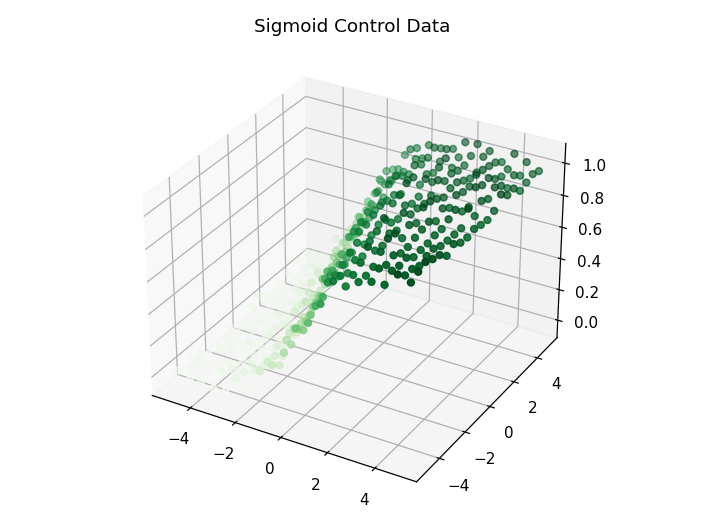

In [4]:
example_weights = np.array([ [ 1.1, 0.3 ] ])
example_biases = np.array([ [ 0.1, 1.0 ] ])
example_mesh_distance = 20

example_fig = plt.figure()
example_ax = plt.axes(projection='3d')

example_ax.set_title('Sigmoid Control Data')
example_fig.tight_layout()

example_x = np.linspace(-5, 5, example_mesh_distance)
example_y = np.linspace(-5, 5, example_mesh_distance)

# We reshape x and y here to be compatible with the matrix format expected by
# the sigmoid_classify function as we defined it.
#
example_xy = np.array(np.meshgrid(example_x, example_y)).T.reshape(-1, 2)
example_z = sigmoid_classify(example_xy, example_weights, example_biases) + np.random.uniform(-0.05, 0.05, example_xy[:,0].shape)

example_ax.scatter3D(example_xy[:,0], example_xy[:,1], example_z, c=example_z, cmap='Greens')

As is custom, we leave the gradient value calculation to the reader to implement below.

<IPython.core.display.Javascript object>


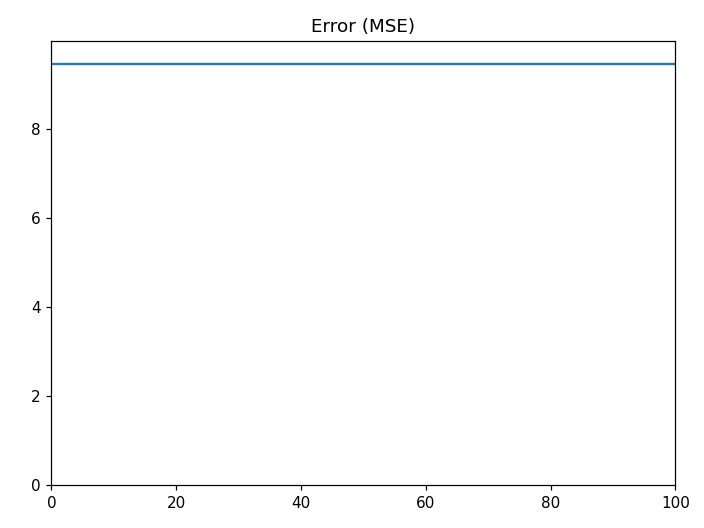

Learned weights after 100 iterations are [[0. 0.]] (control weights were [[0.5 0.9]])
Learned bias after 100 iterations is 0.0 (control bias was 1.2)


In [5]:
fig, (err_ax) = plt.subplots(1, 1)

err_ax.set_title('Error (MSE)')

fig.tight_layout()

control_weights = np.array([ [ 0.5, 0.9 ] ])
control_biases = np.array([ [ 1.0, 0.2 ] ])
mesh_distance = 20
train_iterations = 100

x = np.linspace(-5, 5, mesh_distance)
y = np.linspace(-5, 5, mesh_distance)
xy = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
z = sigmoid_classify(xy, control_weights, control_biases) + np.random.uniform(-0.05, 0.05, xy[:,0].shape)

# Initial guess at weights and biases for our optimal sigmoid function
w = np.array([ [0, 0] ])
b = np.array([ [0, 0] ])

learning_rate = 1.5

def calculate_gradient(weights, biases, xy_pairs, z_vals):
    # Calculate the sigmoid activation function values. These are your predicted values given a
    # particular list of (x, y) coordinate pairs (given in the "xy" function variable).
    #
    sigmoid_vals = sigmoid_classify(xy_pairs, weights, biases)

    # Calculate the difference between the predicted values and the actual data.
    #
    abs_error = np.subtract(sigmoid_vals, z_vals)

    # This is where you should encode the gradient of your loss function.
    #

    # d_weights represents the partial derivatives of the loss function with respect to each weight parameter.
    #
    d_weights = np.array([ 0, 0 ])

    # d_bias represents the partial derivative of the loss function with respect to each bias parameter.
    #
    d_biases = [ 0, 0 ]

    # Calculate mean standard error value
    #
    mse = np.sum(np.power(abs_error, 2)) / len(z_vals)

    return (d_weights, d_biases, mse)

dw, db, err = calculate_gradient(w, b, x, y)

err_vals = [err]
y_predicted = sigmoid_classify(x, w, b)
e, = err_ax.plot(np.arange(0, len(err_vals)), err_vals)


err_ax.set_ylim(bottom=0)
err_ax.set_xlim(left=0, right=train_iterations)

convergence_error_threshold = 0.1
acceptable_min_gradient = 0.01

for i in range(train_iterations):
    w = np.subtract(w, np.multiply(learning_rate, dw))
    b = np.subtract(b, np.multiply(learning_rate, db))

    dw, db, err = calculate_gradient(w, b, x, y)
    err_vals.append(err)

    # Plot error
    #
    e.set_xdata(np.arange(0, len(err_vals)))
    e.set_ydata(err_vals)

    fig.canvas.draw()
    fig.canvas.flush_events()

print('Learned weights after {} iterations are {} (control weights were {})'.format(
    train_iterations,
    w,
    control_weights,
))
print('Learned bias after {} iterations is {} (control bias was {})'.format(
    train_iterations,
    np.sum(b),
    np.sum(control_biases),
))